# 4.5 학습 알고리즘 구현하기

## 신경망 학습 단계

0. 전제: 신경망에는 가중치와 편향이 존재하며, 데이터에 적응시킬 수 있음; 학습이란 이런 매개변수를 훈련 데이터에 적응하도록 조정하는 것
1. 미니배치: 훈련 데이터 중 일부를 무작위로 가져온 것. 이 미니배치에 대해 추론했을 때의 손실함수 출력을 줄이는게 학습의 목표
2. 기울기 산출: 손실함수에서의 가중치 매개변수의 기울기를 구한다. 기울기를 통해 손실함수의 출력을 적게하는 방향을 알 수 있다.
3. 매개변수 갱신: 기울기 방향으로 가중치 매개변수를 살짝 조정한다.
4. 반복

\* 이렇게 미니배치로 무작위로 뽑은 데이터에 대해 작업을 수행하는 이러한 방식을 확률적 경사 하강법(SGD)라고 한다. 루트나 이사의 자료에서 볼 수 있듯이 다양한 방식이 있다.

## 손글씨 숫자를 학습하는 신경망 구현

In [ ]:
# 깡통 2층 신경망 구현

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 임의로 초깃값 세팅
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x): # 여기는 저번에 했던 신경망과 동일하다
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # input
    # x 입력 데이터
    # t 정답 레이블
    def loss(self, x, t):
        """손실함수
        
        Parameters
        ----------
        x: 입력 데이터
        t: 정답 레이블
        
        Returns
        -------
        각 손실함수 출력값
        """
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 정확도 산출
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        """기울기 구하기
        
        Parameters
        ----------
        x: 입력 데이터
        t: 정답 레이블
        
        Returns
        -------
        각 층별 기울기
        """
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 역전파 이용 -> 5장에 나옴
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [ ]:
# 미니배치 학습 구현하기

from ch3.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = [] # 손실 기록
train_acc_list = [] # 정확도 기록
test_acc_list = []

# 하이퍼 패러미터
iter_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니 배치 크기
learning_rate = 0.1 # 학습률

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

net = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iter_num):
    # 미니 배치를 뽑는다
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기를 계산한다
    grad = net.numerical_gradient(x_batch, t_batch)
    # grad = net.gradient(x_batch, t_batch) # 역전파를 이용하는 방법. 훨씬 빠르다. 5장에서 나온다.

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = net.accuracy(x_train, t_train)
        test_acc = net.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 아 너무 오래걸려...

train acc, test acc | 0.09871666666666666, 0.098


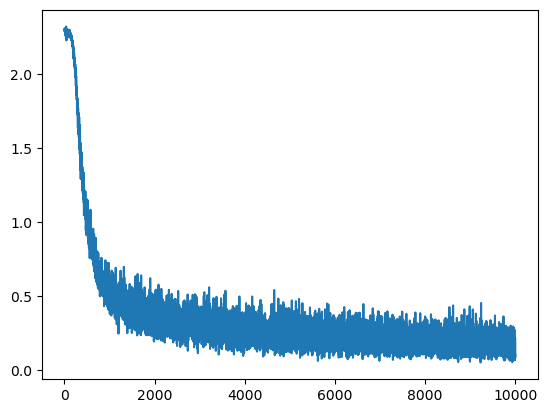

In [11]:
# 손실 시각화
import matplotlib.pylab as plt

y = train_loss_list
plt.plot(y)
plt.show()

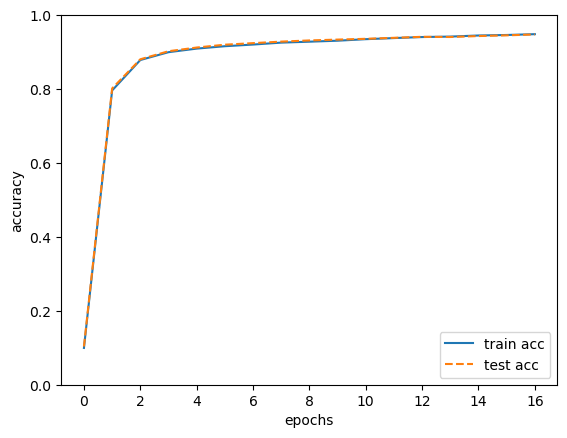

In [ ]:
# 에포크 단위로 정확도 시각화
# 에포크: 학습에서 훈련 데이터를 모두 소진하는 횟수
# - 10,000개 훈련 데이터를 100개의 미니배치로 학습하는 경우,
#   100회 반복해야 해당하는 훈련 데이터를 소진하게 됨
#   => 100회가 1에포크

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 학습 데이터에 대한 정확도 추이와 시험 데이터에 대한 정확도 추이가 거의 같다 => 과대 적합이 이뤄지지 않았음